# <span style="color:blue; font-weight:bold;">4강. 데이터 정제와 그래프 시각화</span>
- 둘째마당 (07-08장)
- pp.177-221

In [2]:
# 그래프 해상도 설정
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.dpi' : '100'})
%config InlineBackend.figure_format = 'retina'

# 07. 데이터 정제 - 빠진 데이터, 이상한 데이터 제거하기

## 07-1. 빠진 데이터를 찾아라! - 결측치 정제하기 (178-185쪽)

#### 결측치 만들기
- Numpy 패키지의 np.nan을 입력 -> NaN으로 표시

In [1]:
import pandas as pd
import numpy as np

df = pd.DataFrame({'sex'   : ['M', 'F', np.nan, 'M', 'F'],
                   'score' : [5, 4, 3, 4, np.nan]})
df

,sex,score
0,M,5.0
1,F,4.0
2,NaN,3.0
3,M,4.0
4,F,NaN


#### 결측치 확인하기
- pd.isna()를 이용하면 결측치 포함 여부를 알 수 있다.
- pd.isna().sum()으로 결측치 총 개수를 알 수 있다.

In [29]:
pd.isna(df)

,sex,score
0,False,False
1,False,False
2,False,False
3,True,False
4,False,False
5,False,True


In [30]:
pd.isna(df).sum()

sex      1
score    1
dtype: int64

### [Do it! 실습] 결측치 제거하기(180쪽)
- df.dropna() 이용하면 결측치가 있는 "행"을 제거할 수 있다.
- 이 때 제거할 결측치의 위치는 subset에 대괄호([])를 이용해서 변수명을 입력한다.

#### 결측치 있는 행 제거하기

In [8]:
df_nomiss = df.dropna(subset = ['score']) # score의 결측치 제거
df_nomiss

,sex,score
0,M,5.0
1,F,4.0
2,NaN,3.0
3,M,4.0


In [12]:
# 결측치 제거된 상태의 연산
df_nomiss['score'] + 1

0    6.0
1    5.0
2    4.0
3    5.0
Name: score, dtype: float64

#### 여러 번수에 결측치 없는 데이터 추출하기
- df.dropna()의 subset에 변수를 나열하면, 여러 변수에 결측치가 없는 행을 추출할 수 있다.

In [7]:
df_nomiss = df.dropna(subset = ['score', 'sex'])
df_nomiss

,sex,score
0,M,5.0
1,F,4.0
3,M,4.0


## 07-2. 이상한 데이터를 찾아라! - 이상치 정제하기 (186-195쪽)
- 이상치 : 정상 범위에서 크게 벗어난 값
- 이상치가 들어 있으면 분석 결과가 왜곡되므로 분석에 앞서 이상치를 제거하는 작업을 해야 함

### [Do it! 실습] 이상치 제거하기 - 존재할 수 없는 값(186쪽)
- 논리적으로 존재할 수 없는 값이 들어 있을 때가 있다.
    - 예 : 남자는 1, 여자는 2로 되어 있는 성별 변수에 3이라는 값이 들어있는 경우

In [18]:
# 이상치 들어 있는 데이터 생성 (1, 2로 분류되는 'sex' 변수, 1~5점으로 된 score 변수)

df = pd.DataFrame({'sex'   : [1, 2, 1, 3, 2, 1],
                   'score' : [5, 4, 3, 4, 2, 6]})
df

,sex,score
0,1,5
1,2,4
2,1,3
3,3,4
4,2,2
5,1,6


#### 이상치 확인하기
- df.value_counts() 이용해 빈도표를 만들면 됨

In [14]:
df['sex'].value_counts().sort_index()
# df.value_counts()에 sort_index()를 적용하면 빈도 기준으로 내림차순 정렬하지 않고, 변수의 값 순서로 정렬

sex
1    3
2    2
3    1
Name: count, dtype: int64

In [15]:
df['score'].value_counts().sort_index()

score
2    1
3    1
4    2
5    1
6    1
Name: count, dtype: int64

#### 결측 처리하기
- 확인한 이상치를 결측치로 변환
- np.where()를 이용해 이상치에 NaN을 부여

In [27]:
# sex가 3일때, score가 5초과일 때 NaN 부여
import numpy as np
df = df.assign(sex = lambda x: np.where(x['sex'] == 3, np.nan, x['sex']), 
             score = lambda x: np.where(x['score'] > 5, np.nan, x['score']))
df

,sex,score
0,1.0,5.0
1,2.0,4.0
2,1.0,3.0
3,NaN,4.0
4,2.0,2.0
5,1.0,NaN


In [28]:
# df.dropna() 이용해 결측치 제거한 다음 성별에 따른 score 평균을 구한다.
df.dropna(subset = ['sex', 'score']) \
  .groupby('sex') \
  .agg(score_mean = ('score', 'mean'))

,score_mean
sex,
1.0,4.0
2.0,3.0


### [Do it! 실습] 이상치 제거하기 - 극단적인 값(190쪽)
- 논리적으로 존재할 수 있지만 극단적으로 크거나 작은 값 = 극단치
    - 예 : 몸무게 변수에 200kg 이상의 값이 있는 경우
- 극단치 제거 위해서는 먼저 어디까지를 정상 범위로 볼 것인가를 정해야 함
    - 논리적 판단에 의한 방법 : 성인 몸무게의 정상 범위를 40~150kg로 설정
    - 통계적 기준 이용 : 상하위 0.3% 또는 +-3 표준편차에 해당하는 값을 극단치로 간주
- 상자 그림으로 극단치 기준 정하기
    - 상자 그림 : 데이터의 분포를 직사각형의 상자 모양으로 표현한 그래프 -> 데이터의 분포를 한눈에 알 수 있음

#### 상자 그림 살펴보기
- mpg 데이터의 hwy 변수로 상자 그림 작성. seaborn 패키지의 boxplot() 이용

<Axes: ylabel='hwy'>

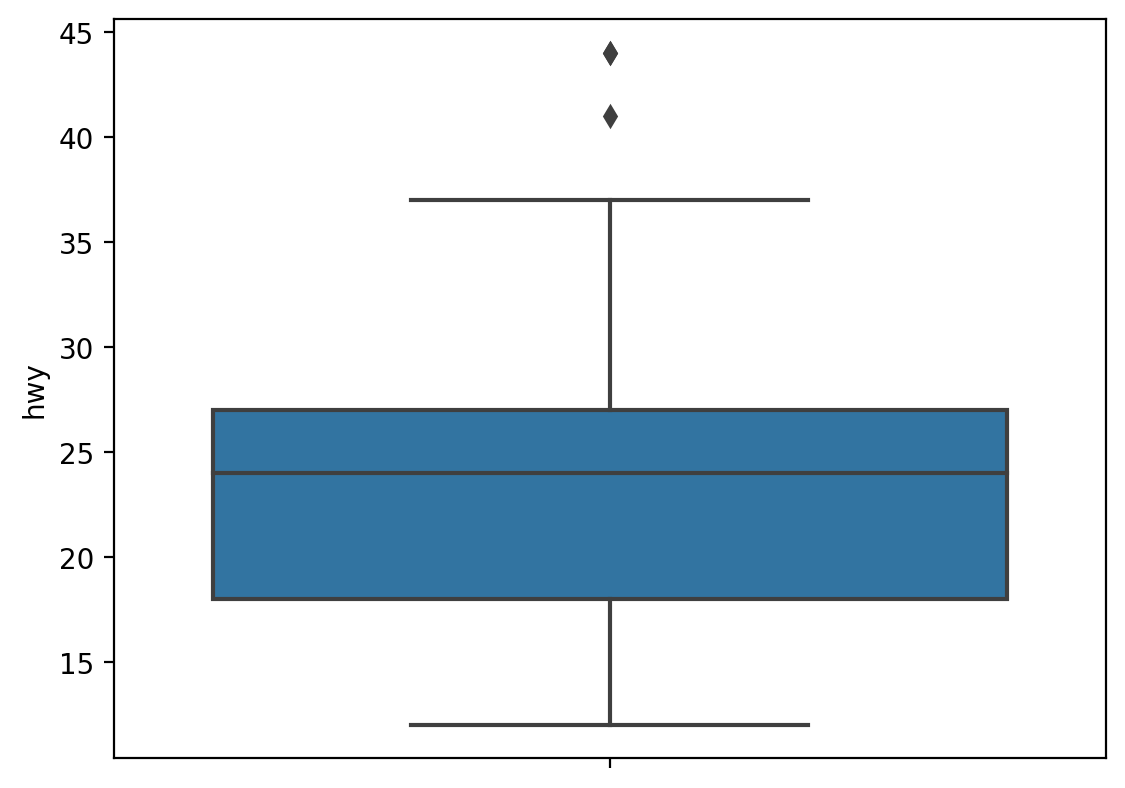

In [31]:
import pandas as pd
mpg = pd.read_csv('mpg.csv')

import seaborn as sns
sns.boxplot(data = mpg, y = 'hwy')

- 상자 그림 : 값을 크기 순으로 나열해 4등분 했을 때 위치하는 값인 '사분위수'를 이용해 만듦
- 상자 그림의 요소가 나타내는 값 -> 교재 191쪽

- [quantile, quartile, percentile 개념 정리](https://blog.eunsukim.me/posts/understanding-quantile-quartile-and-percentile)

#### 극단치 기준값 구하기

In [32]:
# 1사분위수, 3사분위수 구하기 : df.quantile() 이용
pct25 = mpg['hwy'].quantile(.25) # 하위 25%에 해당하는 1사분위수
pct75 = mpg['hwy'].quantile(.75) # 하위 75%에 해당하는 3사분위수

# IQR 구하기 : IQR(inter quartile range, 사분위 범위) <- 1사분위수와 3사분위수 간의 거리
iqr = pct75 - pct25
iqr

9.0

In [33]:
# 하한, 상한 구하기 : 극단치의 경계값 (하한 - 1사분위수보다 'IQR의 1.5배'만큼 더 작은 값, 상한 - 3사분위수보다 더 큰 값)
print(pct25 - 1.5 * iqr) # 하한
print(pct75 + 1.5 * iqr) # 상한

4.5
40.5


In [34]:
# 극단치를 결측 처리하기 : np.where() 이용. 여러 조건 입력시 각 조건을 괄호로 감싸도록 주의
import numpy as np
mpg['hwy'] = np.where((mpg['hwy'] < 4.5) | (mpg['hwy'] > 40.5), np.nan, mpg['hwy'])

# 결측치 빈도 확인
mpg['hwy'].isna().sum()

3

In [35]:
# 해당 값 확인
mpg[mpg['hwy'].isna()]

,manufacturer,model,displ,year,cyl,trans,drv,cty,hwy,fl,category
212,volkswagen,jetta,1.9,1999,4,manual(m5),f,33,NaN,d,compact
221,volkswagen,new beetle,1.9,1999,4,manual(m5),f,35,NaN,d,subcompact
222,volkswagen,new beetle,1.9,1999,4,auto(l4),f,29,NaN,d,subcompact


In [36]:
# 결측치 제거하고 분석하기 : 제거 -> drv(구동방식)에 따라 hwy 평균이 어떻게 다른지 알아보기
mpg.dropna(subset = ['hwy']) \
   .groupby('drv') \
   .agg(mean_hwy = ('hwy', 'mean'))

,mean_hwy
drv,
4,19.174757
f,27.728155
r,21.000000


# 08. 그래프 만들기
- 데이터를 그래프로 표현하면 특징을 쉽게 이해할 수 있다.

## 08-1. 파이썬으로 만들 수 있는 그래프 살펴보기(197-198쪽)
- 그래프 : 데이터를 보기 쉽게 그림으로 표현한 것
- 데이터를 그래프로 표현하면 추세와 경향성이 드러나기 때문에 특징을 쉽게 이해할 수 있고, 그래프를 만드는 과정에서 새로운 패턴을 발견하기도 한다.
- 분석 결과를 발표할 때, 그래프를 활용하면 데이터의 특징을 잘 전달할 수 있다.

- seaborn은 그래프를 만들 때 많이 사용하는 패키지

## 08-2. 산점도 - 변수 간 관계 표현하기(199-204쪽)
- 산점도(scatter plot) : 데이터를 x축과 y축에 점으로 표현한 그래프
- 나이와 소득처럼 **연속값으로 된 두 변수의 관계를 표현**할 때 사용

### [Do it! 실습] 산점도 만들기(199쪽)
- sns.scatterplot() 이용
- data에 그래프를 그리는 데 사용할 데이터 프레임을 입력,
- x축과 y축에 사용할 변수를 ''를 이용해 문자 형태로 입력

In [37]:
# mpg 데이터 불러옴

import pandas as pd
mpg = pd.read_csv('mpg.csv')
mpg.head()

,manufacturer,model,displ,year,cyl,trans,drv,cty,hwy,fl,category
0,audi,a4,1.8,1999,4,auto(l5),f,18,29,p,compact
1,audi,a4,1.8,1999,4,manual(m5),f,21,29,p,compact
2,audi,a4,2.0,2008,4,manual(m6),f,20,31,p,compact
3,audi,a4,2.0,2008,4,auto(av),f,21,30,p,compact
4,audi,a4,2.8,1999,6,auto(l5),f,16,26,p,compact


<Axes: xlabel='displ', ylabel='hwy'>

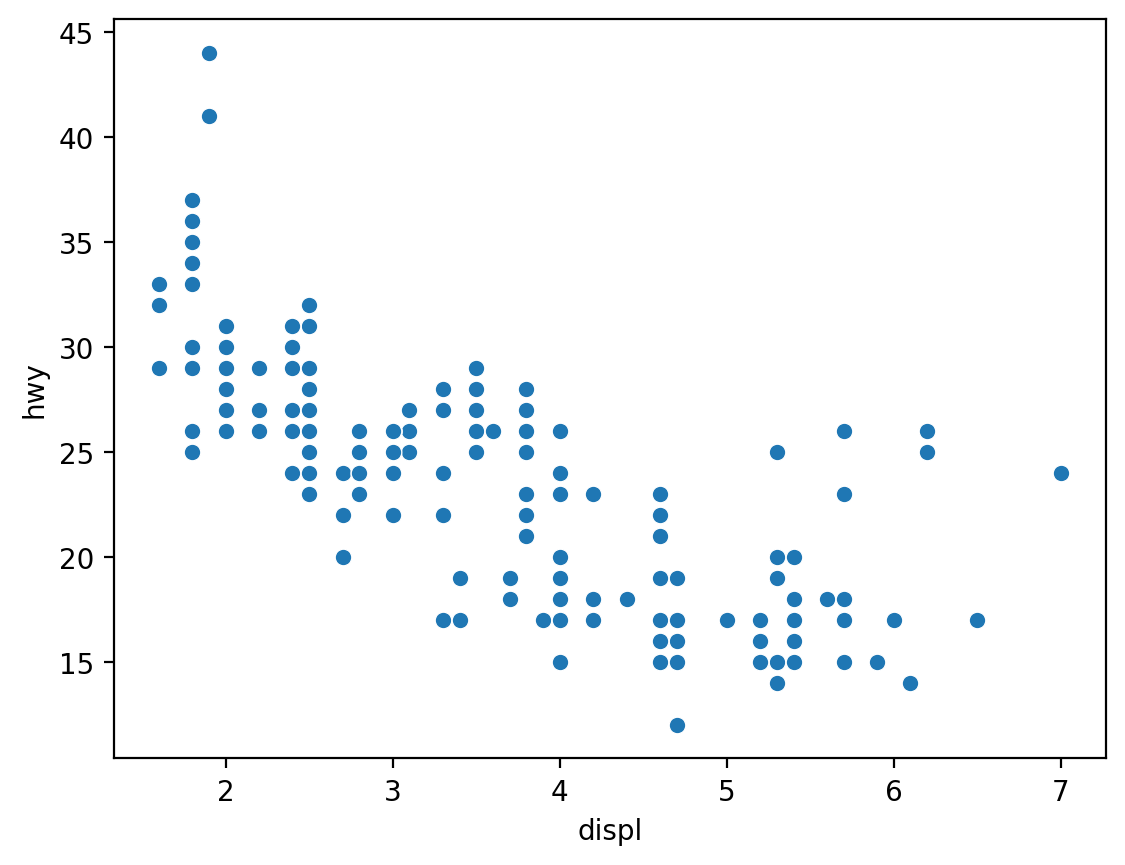

In [38]:
# x축은 displ, y축은 hwy를 나타낸 산점도 만들기

import seaborn as sns
sns.scatterplot(data = mpg, x = 'displ', y = 'hwy')

#### 종류별로 표식 색깔 바꾸기
- hue 이용

<Axes: xlabel='displ', ylabel='hwy'>

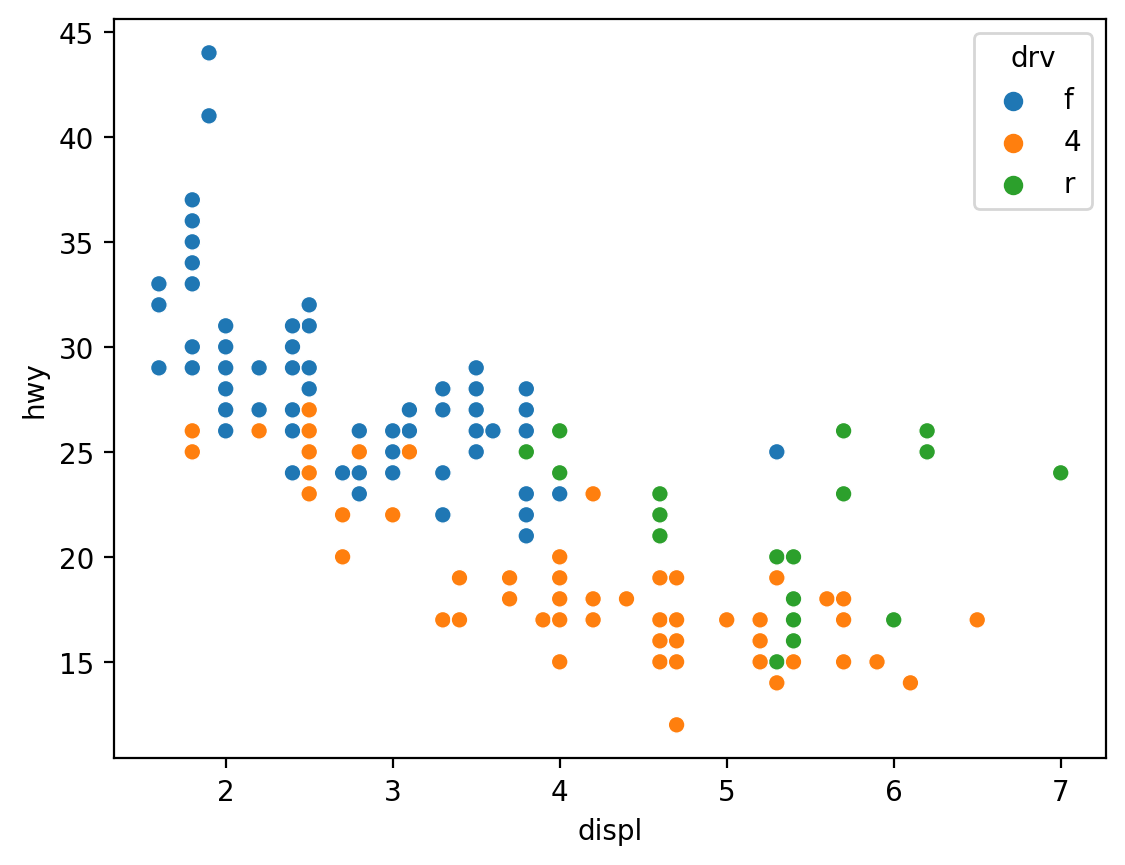

In [50]:
# drv(구동 방식)별로 표식 색깔 다르게 표현

sns.scatterplot(data = mpg, x = 'displ', y = 'hwy', hue = 'drv')

## 08-3. 막대 그래프 - 집단 간 차이 표현하기(205-211쪽)
- 막대그래프(bar chart) : 데이터의 크기를 막대의 길이로 표현한 그래프
- 성별 소득 차이처럼 집단 간 차이를 표현할 때 자주 사용

### [Do it! 실습] 평균 막대 그래프 만들기(205쪽)
- 평균 막대 그래프 : 평균값의 크기를 막대 길이로 표현한 그래프

#### 집단별 평균표 만들기

In [39]:
# drv(구동 방식)별 hwy(고속도로 연비) 평균

df_mpg = mpg.groupby('drv') \
            .agg(mean_hwy = ('hwy', 'mean'))
df_mpg

,mean_hwy
drv,
4,19.174757
f,28.160377
r,21.000000


In [40]:
# drv(구동 방식)별 hwy(고속도로 연비) 평균 
## - seaborn 그래프 위해서는, 위 결과에서 drv가 인덱스 아닌 변수 값으로 나오게 해야 함
## - df.groupby()에 as_index = False 입력하면 됨

df_mpg = mpg.groupby('drv', as_index = False) \
            .agg(mean_hwy = ('hwy', 'mean'))
df_mpg

,drv,mean_hwy
0,4,19.174757
1,f,28.160377
2,r,21.000000


#### 그래프 만들기
- sns.barplot() 이용
- data에 데이터 프레임을 지정, x축에 범주를 나타낸 변수, y축에 평균값을 나타낸 변수를 지정

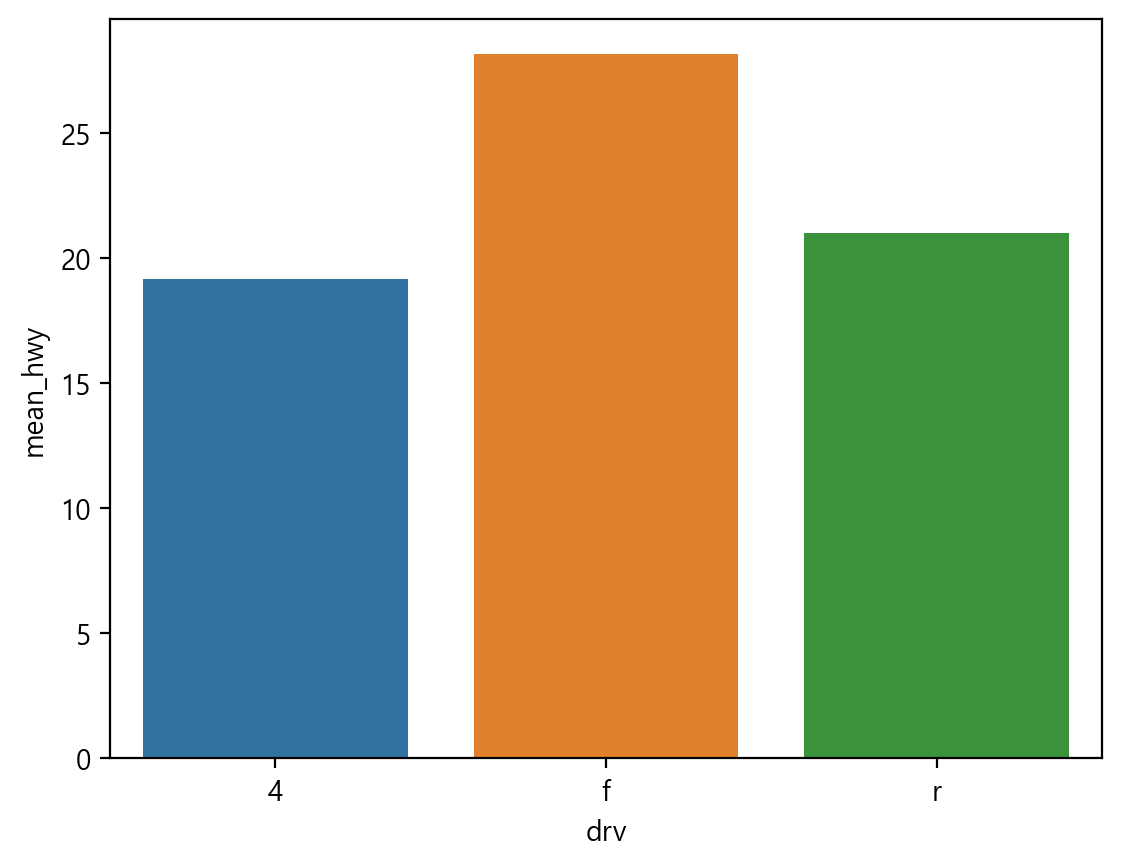

In [64]:
# drv별 hwy 평균을 나타낸 막대 그래프

sns.barplot(data = df_mpg, x = 'drv', y = 'mean_hwy');

#### sns.countplot()으로 빈도 막대 그래프 만들기
- df.groupby()와 df.agg() 이용하는 작업 생략하고,
- sns.countplot()로 곧바로 빈도 막대 그래프 만들 수 있다.

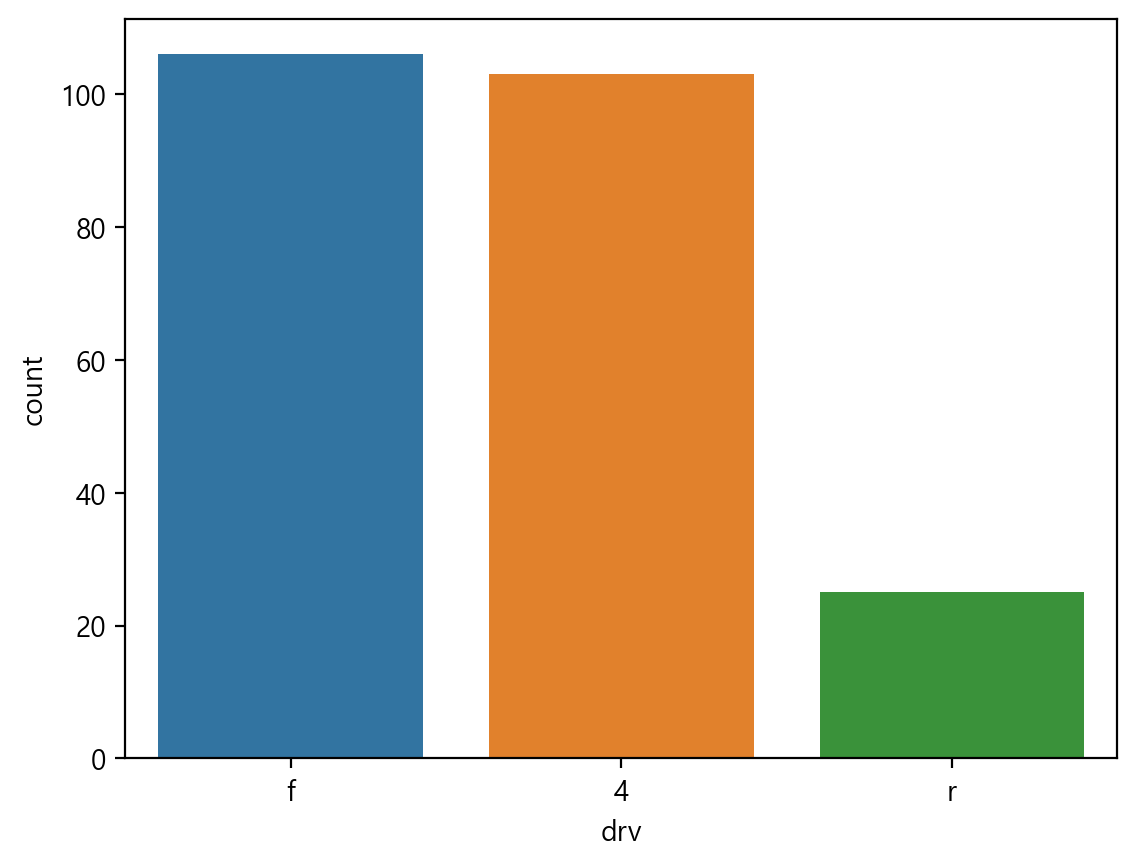

In [68]:
# 빈도 막대 그래프 만들기
sns.countplot(data = mpg, x = 'drv');

## 08-4. 선 그래프 - 시간에 따라 달라지는 데이터 표현하기(212-217쪽)
- 선 그래프 : 데이터를 선으로 표현한 그래프. 시간에 따라 달라지는 데이터를 표현할 때 자주 사용.
    - 예) 환율, 주가지수 등 경제지표가 시간에 따라 변하는 양상
    - 시계열 데이터 : 일별 환율처럼, 일정 시간 간격을 두고 나열된 데이터
    - 시계열 그래프 : 시계열 데이터를 선으로 표현한 그래프

### [Do it! 실습] 시계열 그래프 만들기(212쪽)
- economics 데이터 : 미국의 여러 경제 지표를 월별로 나타낸 데이터
- economics 데이터 이용해서 시간에 따라 실업자 수가 변하는 시계열 그래프 작성
- economics 데이터 출처 : bit.ly/easypy_85

In [41]:
# economics 데이터 불러오기
import pandas as pd
economics = pd.read_csv('economics.csv')
print(economics.shape)
economics.head()

(574, 6)


,date,pce,pop,psavert,uempmed,unemploy
0,1967-07-01,506.7,198712.0,12.6,4.5,2944
1,1967-08-01,509.8,198911.0,12.6,4.7,2945
2,1967-09-01,515.6,199113.0,11.9,4.6,2958
3,1967-10-01,512.2,199311.0,12.9,4.9,3143
4,1967-11-01,517.4,199498.0,12.8,4.7,3066


#### x축에 연도 표시하기
- 먼저 변수 타입을 날짜 시간 타입(datetime64)으로 변경해야 함
- 현재 상태 : date가 문자(object) 타입으로 되어 있다

##### 날짜 시간 타입 변수 만들기
- pd.to_datetime() 이용하면 변수 타입을 날짜 시간 타입으로 변경 가능

In [7]:
# 날짜 시간 타입 변수 만들기
economics['date2'] = pd.to_datetime(economics['date'])

# 변수 타입 확인
economics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 574 entries, 0 to 573
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      574 non-null    object        
 1   pce       574 non-null    float64       
 2   pop       574 non-null    float64       
 3   psavert   574 non-null    float64       
 4   uempmed   574 non-null    float64       
 5   unemploy  574 non-null    int64         
 6   date2     574 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 31.5+ KB


In [ ]:
# 변수가 날짜 시간 타입으로 되어 있으면 df.dt를 이용해 연, 월, 일을 추출할 수 있다

In [9]:
# 연 추출
economics['date2'].dt.year

0      1967
1      1967
2      1967
3      1967
4      1967
       ... 
569    2014
570    2015
571    2015
572    2015
573    2015
Name: date2, Length: 574, dtype: int32

In [10]:
# 월 추출
economics['date2'].dt.month

0       7
1       8
2       9
3      10
4      11
       ..
569    12
570     1
571     2
572     3
573     4
Name: date2, Length: 574, dtype: int32

In [11]:
# 일 추출
economics['date2'].dt.day

0      1
1      1
2      1
3      1
4      1
      ..
569    1
570    1
571    1
572    1
573    1
Name: date2, Length: 574, dtype: int32

#### 연도 변수 만들기

In [12]:
# 연도 변수 추가
economics['year'] = economics['date2'].dt.year
economics.head()

,date,pce,pop,psavert,uempmed,unemploy,date2,year
0,1967-07-01,506.7,198712.0,12.6,4.5,2944,1967-07-01,1967
1,1967-08-01,509.8,198911.0,12.6,4.7,2945,1967-08-01,1967
2,1967-09-01,515.6,199113.0,11.9,4.6,2958,1967-09-01,1967
3,1967-10-01,512.2,199311.0,12.9,4.9,3143,1967-10-01,1967
4,1967-11-01,517.4,199498.0,12.8,4.7,3066,1967-11-01,1967


#### x축에 연도 표시하기

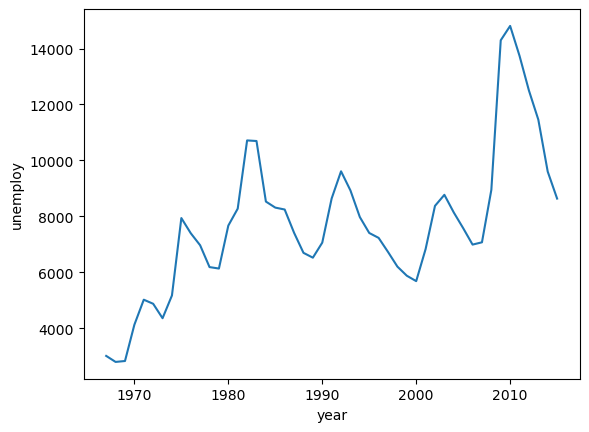

In [15]:
sns.lineplot(data = economics, x = 'year', y = 'unemploy', errorbar = None);

## 08-5. 상자 그림 - 집단 간 분포 차이 표현하기(218-220쪽)

- 상자 그림(box plot): 데이터의 분포 또는 퍼져 있는 형태를 직사각형 상자 모양으로 표현한 그래프.
- 평균값을 볼 때보다 데이터의 특징을 더 자세히 이해할 수 있다.

### [Do it! 실습] 상자 그림 만들기(218쪽)

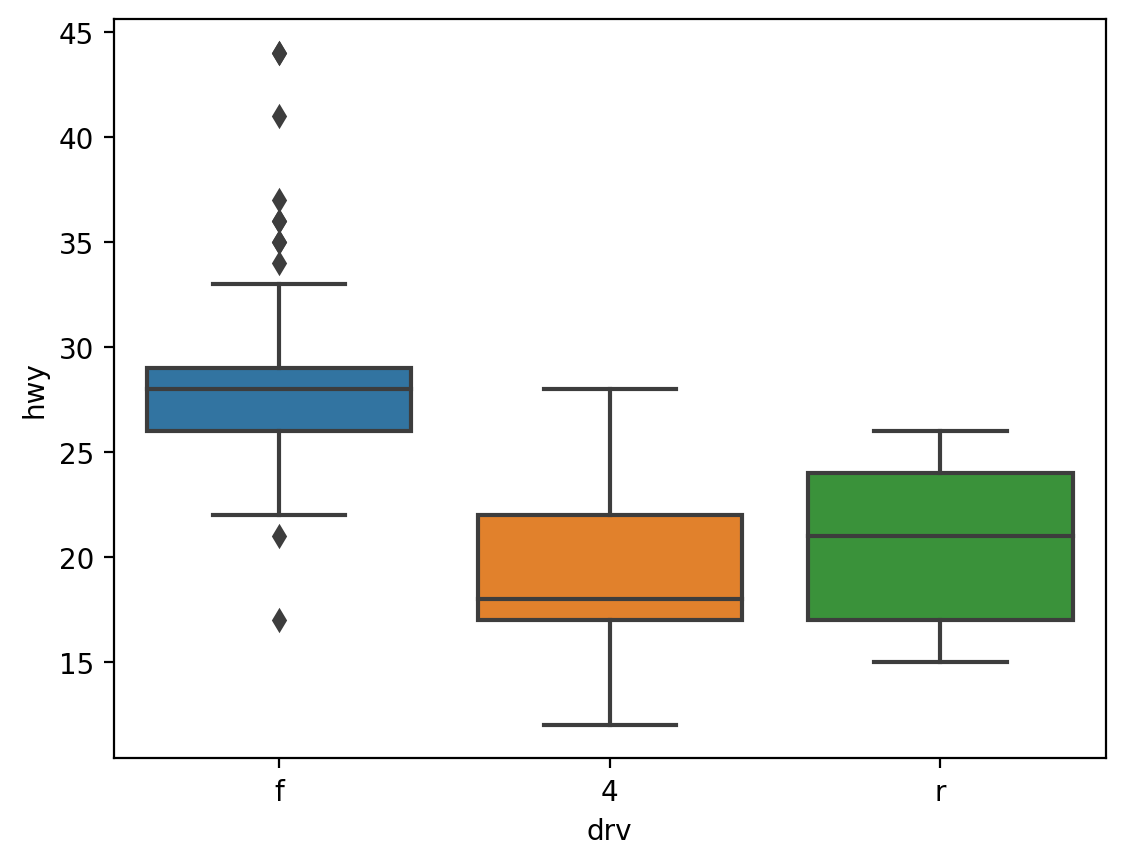

In [45]:
# mpg로 구동 방식별 고속도로 연비를 상자 그림으로 표현: 값 "자체" > 값 개수
mpg = pd. read_csv('mpg.csv')
sns.boxplot(data = mpg, x = 'drv', y = 'hwy');

In [46]:
mpg.head(3)

,manufacturer,model,displ,year,cyl,trans,drv,cty,hwy,fl,category
0,audi,a4,1.8,1999,4,auto(l5),f,18,29,p,compact
1,audi,a4,1.8,1999,4,manual(m5),f,21,29,p,compact
2,audi,a4,2.0,2008,4,manual(m6),f,20,31,p,compact


In [55]:
# 상자 그림 이해 위한 작업: drv의 값 종류 파악

mpg.groupby('drv') \
   .agg(n = ('hwy', 'count')) \
   .sort_values(by = 'n', ascending = False)

,n
drv,
f,106
4,103
r,25


In [61]:
mpg_f = mpg.query('drv == "f"') \
           [['drv', 'hwy']] \
           .sort_values(by = 'hwy', ascending = False)
mpg_f

,drv,hwy
221,f,44
212,f,44
222,f,41
196,f,37
106,f,36
...,...,...
40,f,22
39,f,22
44,f,22
45,f,21


In [62]:
# 정상 범위 벗어난 값

pct25 = mpg_f['hwy'].quantile(.25)
pct75 = mpg_f['hwy'].quantile(.75)
iqr = pct75 - pct25
lowest = pct25 - iqr * 1.5  # 하한
highest = pct75 + iqr * 1.5 # 상한
print(lowest)
print(highest)

21.5
33.5


In [70]:
mpg_f.query('hwy > 33.5 | hwy < 21.5') \
     .groupby('hwy') \
     .agg(n = ('hwy', 'count')) \
     .sort_index(ascending = False)

,n
hwy,
44,2
41,1
37,1
36,2
35,2
34,1
21,1
17,1


# The End of Notebook